In [1]:
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd     
from sklearn.metrics import accuracy_score        

In [2]:
#Define Directories for train, test & Validation Set
train_path = './data/train'
test_path = './data/test'
valid_path = './data/validation'

In [3]:
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 img_height = 500
img_width = 128
img_height = 128

In [4]:
from keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(rescale=1./255,rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

train = image_gen.flow_from_directory(train_path,
      target_size=(img_height, img_width), 
      shuffle=True,
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

images_train, labels_train = next(train)

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 

      class_mode='binary',
      batch_size=batch_size
      )

valid_data_gen = ImageDataGenerator(rescale = 1./255)
valid = valid_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size,
      shuffle=False,
      )

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])                 

In [6]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.00001)
callbacks_list = [ early, learning_rate_reduction]

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
cnn.fit(train, validation_data=valid, epochs=25,class_weight=cw,callbacks=callbacks_list)

/opt/anaconda3/envs/cpsc390/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/25
102/102 [==============================] - 9s 82ms/step - loss: 0.6632 - accuracy: 0.5728 - val_loss: 0.3090 - val_accuracy: 0.9056
Epoch 2/25
102/102 [==============================] - 8s 76ms/step - loss: 0.3532 - accuracy: 0.8664 - val_loss: 0.2528 - val_accuracy: 0.9167
Epoch 3/25
102/102 [==============================] - 8s 78ms/step - loss: 0.2976 - accuracy: 0.9013 - val_loss: 0.2574 - val_accuracy: 0.9222
Epoch 4/25
102/102 [==============================] - 9s 88ms/step - loss: 0.2274 - accuracy: 0.9249 - val_loss: 0.2581 - val_accuracy: 0.9167

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/25
102/102 [==============================] - 9s 89ms/step - loss: 0.1969 - accuracy: 0.9361 - val_loss: 0.1862 - val_accuracy: 0.9389
Epoch 6/25
102/102 [==============================] - 10s 93ms/step - loss: 0.1671 - accuracy: 0.9475 - val_loss: 0.1802 - val_accuracy: 0.9444
Epoch 7/25
102/102 [==============================] - 9s 88m

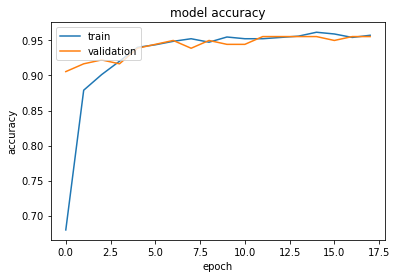

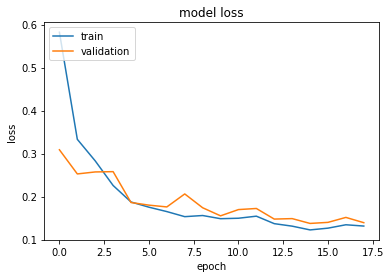

In [7]:
# plot accuracy
plt.figure()
plt.plot(cnn.history.history['accuracy'])
plt.plot(cnn.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# plot  loss
plt.figure()
plt.plot(cnn.history.history['loss'])
plt.plot(cnn.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [8]:
preds = cnn.predict(test)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1
from sklearn.metrics import classification_report,confusion_matrix
acc=accuracy_score(test.classes, predictions)
cm = confusion_matrix(test.classes, predictions)
tn, fp, fn, tp = cm.ravel()
print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


TEST METRICS ----------------------
Accuracy: 0.96%
Precision: 97.91666666666666%
Recall: 94.0%
F1-score: 95.91836734693878


              precision    recall  f1-score   support

       covid       0.94      0.98      0.96       100
      normal       0.98      0.94      0.96       100

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



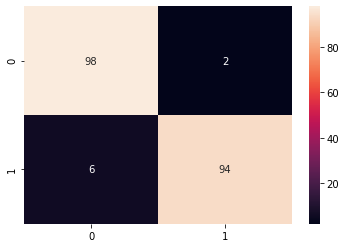

In [9]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['covid','normal']))
